## 神经网络用于计算机视觉

本章包括以下内容：

- 理解卷积神经网络（ConvNet）
- 使用数据增强（data argument）来降低过拟合
- 使用预训练的CNN进行特征提取
- 微调预训练的CNN
- 将CNN学到的内容及其如何做出分类决策可视化

In [20]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers, optimizers, losses, metrics

model = models.Sequential()
model.add(
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                36928     
__________

In [7]:
# 在MNIST上训练CNN
from keras.datasets import mnist
from keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape((60000, 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [70]:
model.compile(
    optimizer=optimizers.RMSprop(),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy])

In [71]:
model.fit(train_images, train_labels, epochs=5, batch_size=64)

Epoch 1/5
60000/60000 [==============================] - 6s 98us/step - loss: 0.1730 - categorical_accuracy: 0.9467
Epoch 2/5
60000/60000 [==============================] - 6s 93us/step - loss: 0.0476 - categorical_accuracy: 0.9855
Epoch 3/5
60000/60000 [==============================] - 5s 90us/step - loss: 0.0327 - categorical_accuracy: 0.9900
Epoch 4/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0252 - categorical_accuracy: 0.9923
Epoch 5/5
60000/60000 [==============================] - 6s 92us/step - loss: 0.0208 - categorical_accuracy: 0.9937


In [72]:
model.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 64us/step


[0.031015461185939057, 0.9908]

In [73]:
model.save('mnist_cnn1.h5')

In [75]:
results = model.predict(test_images[:6], batch_size=1, verbose=1)
np.argmax(results, axis=1)

6/6 [==============================] - 0s 2ms/step


array([7, 2, 1, 0, 4, 1])

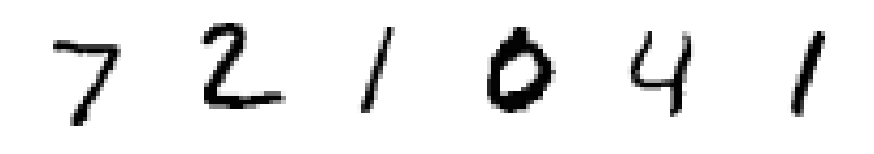

In [87]:
f, ax = plt.subplots(1, 6, figsize=(15,3))
for i, img in enumerate(test_images[:6]):
    ax[i].imshow(img.reshape(28, 28), cmap=plt.cm.binary)
    ax[i].axis('off')
plt.show()    